In [1]:
#Importing all necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import s3fs
import os
from matplotlib import pyplot as plt 

In [2]:
#Loading datasets
non_event =pd.read_parquet("s3://capstonemlc/NoDuplicates_backup/non_event.parquet")
event=pd.read_parquet("s3://capstonemlc/NoDuplicates_backup/event.parquet")
app=pd.read_parquet("s3://capstonemlc/NoDuplicates_backup/app.parquet")

In [3]:
#Print the size (rows and columns) in all the data frames
print("non_event = ",non_event.shape," Rows = ",non_event.shape[0]," Columns = ",non_event.shape[1])
print("event = ",event.shape," Rows = ",event.shape[0]," Columns = ",event.shape[1])
print("app = ",app.shape," Rows = ",app.shape[0]," Columns = ",app.shape[1])

non_event =  (74646, 6)  Rows =  74646  Columns =  6
event =  (1266933, 8)  Rows =  1266933  Columns =  8
app =  (208074434, 6)  Rows =  208074434  Columns =  6


# Feature Engineering

In [4]:
#first 5 rows
event.head()

,device_id,gender,age,group_train,event_id,date_time,longitude,latitude
0,-1000369272589010000,F,26,F25-32,NaN,None,NaN,NaN
1,-1000572055892390000,F,27,F25-32,NaN,None,NaN,NaN
2,-1000643208750510000,M,29,M25-32,NaN,None,NaN,NaN
3,-1001337759327040000,M,30,M25-32,2774404.0,2016-05-07 09:14:24,119.0,29.70
4,-1001337759327040000,M,30,M25-32,3065018.0,2016-05-04 10:26:14,120.0,30.42


In [5]:
#changing the datatype
event['date_time']= pd.to_datetime(event['date_time'])

#Extracting day of the week and hour from date_time variable
event['hour'] = event['date_time'].dt.hour
event['dayofweek'] = event['date_time'].dt.day_name()

#setting proper data types
event["hour"] = event["hour"].astype(pd.Int32Dtype())

In [6]:
#Shape
event.shape

(1266933, 10)

### Median of Latitude and Longitude

In [7]:
#Grouping device_ids based on their median longitude and latutude
event_median_location = event.groupby('device_id')[['longitude','latitude']].median().reset_index()

In [8]:
#Renaming columns
event_median_location.columns = ['device_id','median-longitude','median-latitude']

In [9]:
#merging app_label and app_events
event= event.merge(event_median_location,on="device_id", how="left")

### Number of events on different hours of the day

In [10]:
#dropping missing values and creating a new dataframe
e=event.dropna()

In [11]:
#Defining a function that returns the phase of the day at which the event occurred.

def binhour(x):
    if x < 5:
        return "midnight"
    elif x < 8:
        return "early_morning"
    elif x < 20:
        return "daytime"
    elif x< 23:
        return "night"
    else:
        return "midnight"

In [12]:
#applying function
e['hour_bin'] =e['hour'].apply(binhour)

/home/ec2-user/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
#first 5 rows
e.head()

,device_id,gender,age,group_train,event_id,date_time,longitude,latitude,hour,dayofweek,median-longitude,median-latitude,hour_bin
3,-1001337759327040000,M,30,M25-32,2774404.0,2016-05-07 09:14:24,119.0,29.70,9,Saturday,120.0,30.2,daytime
4,-1001337759327040000,M,30,M25-32,3065018.0,2016-05-04 10:26:14,120.0,30.42,10,Wednesday,120.0,30.2,daytime
5,-1001337759327040000,M,30,M25-32,3230344.0,2016-05-04 10:04:42,120.0,30.41,10,Wednesday,120.0,30.2,daytime
6,-1001337759327040000,M,30,M25-32,2906128.0,2016-05-07 10:24:32,119.0,29.80,10,Saturday,120.0,30.2,daytime
7,-1001337759327040000,M,30,M25-32,2876843.0,2016-05-07 10:23:56,119.0,29.80,10,Saturday,120.0,30.2,daytime


In [14]:
# Grouping the data by device_id and getting the information of all the phases at which the event of that device occurred
event_cnt_hours = e.groupby('device_id')['hour_bin'].apply(lambda x: " ".join(s for s in x)).reset_index()

midnight_counts = []
daytime_counts = []
early_morning_counts = []
night_counts = []

# Counting the events which occurred at the specific phases from l_hours_count
for i in range(len(event_cnt_hours)):
    lis = event_cnt_hours['hour_bin'][i].split(' ')
    midnight_counts.append(lis.count('midnight'))
    daytime_counts.append(lis.count('daytime'))
    early_morning_counts.append(lis.count('early_morning'))
    night_counts.append(lis.count('night'))

# Adding the counts column in the data
event_cnt_hours['midnight_counts'] = midnight_counts
event_cnt_hours['daytime_counts'] = daytime_counts
event_cnt_hours['early_morning_counts'] = early_morning_counts
event_cnt_hours['night_counts'] = night_counts

In [15]:
#first 5 rows
event_cnt_hours.head()

,device_id,hour_bin,midnight_counts,daytime_counts,early_morning_counts,night_counts
0,-9222956879900150000,daytime daytime night daytime daytime night ni...,3,50,2,10
1,-9221026417907250000,night night early_morning daytime night night ...,3,55,50,39
2,-9220830859283100000,night midnight night night midnight midnight n...,4,0,0,4
3,-9220061629197650000,daytime daytime early_morning daytime daytime ...,0,44,5,3
4,-9218960997324660000,daytime early_morning night night daytime night,0,2,1,3


In [16]:
#dropping hour bin columns
event_cnt_hours.drop(event_cnt_hours.iloc[:, 1:2], inplace = True, axis = 1)

In [17]:
#merging with event data
event= event.merge(event_cnt_hours,on="device_id", how="left")

### Number of events on days of the week

In [18]:
# Grouping events data according to device_ids and getting all the days at which that particular device performed that events
event_cnt_days = e.groupby('device_id')['dayofweek'].apply(lambda x: " ".join(s for s in x)).reset_index()

monday_counts = []
tuesday_counts = []
wednesday_counts = []
thursday_counts = []
friday_counts = []
saturday_counts = []
sunday_counts = []

# Getting the counts of events that occurred on a specific data
for i in range(len(event_cnt_days)):
    lis = event_cnt_days['dayofweek'][i].split(' ')
    monday_counts.append(lis.count('Monday'))
    tuesday_counts.append(lis.count('Tuesday'))
    wednesday_counts.append(lis.count('Wednesday'))
    thursday_counts.append(lis.count('Thursday'))
    friday_counts.append(lis.count('Friday'))
    saturday_counts.append(lis.count('Saturday'))
    sunday_counts.append(lis.count('Sunday'))

# Adding the counts column in the dataframe
event_cnt_days['monday_counts'] = monday_counts
event_cnt_days['tuesday_counts'] = tuesday_counts
event_cnt_days['wednesday_counts'] = wednesday_counts
event_cnt_days['thursday_counts'] = thursday_counts
event_cnt_days['friday_counts'] = friday_counts
event_cnt_days['saturday_counts'] = saturday_counts
event_cnt_days['sunday_counts'] = sunday_counts

In [19]:
#first 5 rows
event_cnt_days.head()

,device_id,dayofweek,monday_counts,tuesday_counts,wednesday_counts,thursday_counts,friday_counts,saturday_counts,sunday_counts
0,-9222956879900150000,Friday Saturday Friday Friday Friday Friday Fr...,0,0,0,0,30,35,0
1,-9221026417907250000,Monday Wednesday Thursday Saturday Thursday Mo...,37,16,19,20,14,9,32
2,-9220830859283100000,Tuesday Saturday Thursday Thursday Saturday Th...,0,1,0,5,0,2,0
3,-9220061629197650000,Monday Tuesday Monday Thursday Thursday Wednes...,2,12,13,17,1,1,6
4,-9218960997324660000,Friday Monday Saturday Saturday Tuesday Saturday,1,1,0,0,1,3,0


In [20]:
#dropping day of week columns
event_cnt_days.drop(event_cnt_days.iloc[:, 1:2], inplace = True, axis = 1)

In [21]:
#merging with event data
event= event.merge(event_cnt_days,on="device_id", how="left")

### Data Preparation

In [22]:
#column names
event.columns

Index(['device_id', 'gender', 'age', 'group_train', 'event_id', 'date_time',
       'longitude', 'latitude', 'hour', 'dayofweek', 'median-longitude',
       'median-latitude', 'midnight_counts', 'daytime_counts',
       'early_morning_counts', 'night_counts', 'monday_counts',
       'tuesday_counts', 'wednesday_counts', 'thursday_counts',
       'friday_counts', 'saturday_counts', 'sunday_counts'],
      dtype='object')

In [23]:
#dropping group_train column
event.drop(event.iloc[:, 3:4], inplace = True, axis = 1)

In [24]:
#dropping date_time,latitude longitude, hour,day of week columns
event.drop(event.iloc[:, 4:9], inplace = True, axis = 1)

In [25]:
#renaming columns
event.rename(columns={'median-longitude': 'longitude', 'median-latitude' : "latitude" }, inplace=True)

In [26]:
#first 5 rows
event.head()

,device_id,gender,age,event_id,longitude,latitude,midnight_counts,daytime_counts,early_morning_counts,night_counts,monday_counts,tuesday_counts,wednesday_counts,thursday_counts,friday_counts,saturday_counts,sunday_counts
0,-1000369272589010000,F,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1000572055892390000,F,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1000643208750510000,M,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1001337759327040000,M,30,2774404.0,120.0,30.2,0.0,109.0,0.0,0.0,0.0,7.0,40.0,0.0,11.0,51.0,0.0
4,-1001337759327040000,M,30,3065018.0,120.0,30.2,0.0,109.0,0.0,0.0,0.0,7.0,40.0,0.0,11.0,51.0,0.0


In [27]:
#dropping duplicates
event.drop_duplicates(inplace=True)

In [28]:
#shape
event.shape

(1266933, 17)

### non_event data

In [29]:
#first 5 rows
non_event.head()

,device_id,gender,age,group_train,phone_brand,device_model
0,-7548291590301750000,M,33,M32+,Huawei,è£è€€3C
1,-1819925713085810000,F,23,F0-24,OPPO,N1 Mini
2,3670076507269740000,M,33,M32+,Meizu,menote1 2
3,5333872006968810000,M,34,M32+,Xiaomi,xnote
4,5263633571423510000,M,27,M25-32,Huawei,hu1 Plus


In [30]:
#dropping group_train column
non_event=non_event.drop(['group_train'], axis=1)

In [31]:
#shape
non_event.shape

(74646, 5)

In [32]:
#top 10 phone brands
ph=non_event['phone_brand'].value_counts(sort=True).head(10)

In [33]:
#to data frame
ph=ph.to_frame()

In [34]:
#resetting index
p=ph.reset_index()

In [35]:
#list of top 10 phone brands
brand=p['index'].to_list()

In [36]:
#creating a new column with top 10 phone brands and rest as others
non_event['brand']= [x if x in brand else 'others' for x in non_event['phone_brand']]

In [37]:
#first 20 rows
non_event.head(20)

,device_id,gender,age,phone_brand,device_model,brand
0,-7548291590301750000,M,33,Huawei,è£è€€3C,Huawei
1,-1819925713085810000,F,23,OPPO,N1 Mini,OPPO
2,3670076507269740000,M,33,Meizu,menote1 2,Meizu
3,5333872006968810000,M,34,Xiaomi,xnote,Xiaomi
4,5263633571423510000,M,27,Huawei,hu1 Plus,Huawei
5,4065408380331460000,M,20,Xiaomi,xnote,Xiaomi
6,-3606927452885540000,M,26,Xiaomi,MI 4,Xiaomi
7,4383614216971680000,M,39,samsung,Galaxy Premier,samsung
8,4794091972520650000,M,20,OPPO,R7s,OPPO
9,-6880965893023640000,M,45,Xiaomi,MI 2A,Xiaomi


In [38]:
#top 150 device models
dv=non_event['device_model'].value_counts(sort=True).head(150)

##### Top 150 device models are selected since they comprise of 75% of the total users

In [39]:
#to dataframe
dv=dv.to_frame()

In [40]:
#resetting index
dv=dv.reset_index()

In [41]:
#list of top 10 device models
model=dv['index'].to_list()

In [42]:
#creating a new column with top 10 device models and rest as others
non_event['model']=[x if x in model else 'others' for x in non_event['device_model']]

In [43]:
#first 5 rows
non_event.head()

,device_id,gender,age,phone_brand,device_model,brand,model
0,-7548291590301750000,M,33,Huawei,è£è€€3C,Huawei,è£è€€3C
1,-1819925713085810000,F,23,OPPO,N1 Mini,OPPO,N1 Mini
2,3670076507269740000,M,33,Meizu,menote1 2,Meizu,menote1 2
3,5333872006968810000,M,34,Xiaomi,xnote,Xiaomi,xnote
4,5263633571423510000,M,27,Huawei,hu1 Plus,Huawei,hu1 Plus


In [44]:
#dropping phone_brand and device_model columns
non_event=non_event.drop(non_event.iloc[:,3:5], axis=1)

In [45]:
#dropping duplicates
non_event.drop_duplicates(inplace=True)

In [46]:
#shape
non_event.shape

(74646, 5)

In [47]:
#first 5 rows
non_event.head()

,device_id,gender,age,brand,model
0,-7548291590301750000,M,33,Huawei,è£è€€3C
1,-1819925713085810000,F,23,OPPO,N1 Mini
2,3670076507269740000,M,33,Meizu,menote1 2
3,5333872006968810000,M,34,Xiaomi,xnote
4,5263633571423510000,M,27,Huawei,hu1 Plus


### app data

In [48]:
#first 5 rows
app.head()

,event_id,app_id,is_installed,is_active,label_id,category
0,2,5927333115845830913,1,1,704,Property Industry 2.0
1,2,5927333115845830913,1,1,172,IM
2,2,5927333115845830913,1,1,548,Industry tag
3,2,5927333115845830913,1,1,710,Relatives 1
4,2,5927333115845830913,1,1,549,Property Industry 1.0


In [49]:
app.shape

(208074434, 6)

In [50]:
#filtering apps that are active
app = app[app['is_active'] == 1]

In [51]:
app.shape

(70827670, 6)

In [52]:
#dropping app_id, Is_installed, is_active and label_id columns
app.drop(app.iloc[:, 1:5], inplace = True, axis = 1)

In [53]:
#dropping duplicates
app.drop_duplicates(inplace=True)

In [54]:
app.shape

(32054113, 2)

In [55]:
#first 5 rows
app.head()

,event_id,category
0,2,Property Industry 2.0
1,2,IM
2,2,Industry tag
3,2,Relatives 1
4,2,Property Industry 1.0


In [56]:
#stripping numbers from category column
import string
app['category'] = app['category'].str.rstrip(string.digits)

In [57]:
#replacing
app['category'] = app['category'].replace(['Property Industry 2.', 'Property Industry 1.'], 'Property Industry')

In [58]:
#dropping duplicates
app.drop_duplicates(inplace=True)

In [59]:
#changing string case
app['category'] = app['category'].str.lower()

In [60]:
#list of unknown categiroes
unknownValues = ['and the church','custom label','low risk','high risk','medium risk'\
                 ,'1 free','high flow','cozy','low income','high income','medium income']
#replacing with unknown
app['category'] = app['category'].replace(unknownValues, 'unknown')

In [61]:
#property industry always go hand in hand with industry tag. So, we will drop property industry
app = app[app['category'] != "property industry"]

In [62]:
app = app[app['category'] != "unknown"]

In [63]:
#dropping duplicates
app.drop_duplicates(inplace=True)

In [64]:
#top 50 app categories
cat=app['category'].value_counts(sort=True).head(50)

##### Top 50 apps are selected since this comprises or about 80% of data

In [65]:
#to dataframe
cat=cat.to_frame()

In [66]:
#resetting index
cat=cat.reset_index()

In [67]:
#list of top 50 apps
ctgry=cat['index'].to_list()

In [68]:
#creating a new column with top 50 apps and rest as others
app['ctgry']=[x if x in ctgry else 'others' for x in app['category']]

In [69]:
#first 5 rows
app.head()

,event_id,category,ctgry
1,2,im,im
2,2,industry tag,industry tag
3,2,relatives,relatives
22,2,insurance,others
24,2,direct insurance,others


In [70]:
#dropping category columns
app=app.drop(app.iloc[:,1:2], axis=1)

In [71]:
#dropping duplicates
app.drop_duplicates(inplace=True)

In [72]:
app.head(10)

,event_id,ctgry
1,2,im
2,2,industry tag
3,2,relatives
22,2,others
25,2,finance
26,2,consumer finance
38,2,liquid medium
39,2,wealth management
45,2,services
50,2,bank financing


In [73]:
#renaming columns
app.rename(columns={'ctgry': 'category'}, inplace=True)

In [74]:
#regrouping and resetting index to make app final data
app = app.groupby('event_id')['category'].apply(','.join).reset_index()

In [75]:
#shape
app.shape

(1456704, 2)

In [76]:
#dropping duplicates
app.drop_duplicates(inplace=True)

In [77]:
#shape
app.shape

(1456704, 2)

In [78]:
#first 5 rows
app.head()

,event_id,category
0,2,"im,industry tag,relatives ,others,finance,cons..."
1,6,"others,industry tag,personal effectiveness ,se..."
2,7,"taxi,industry tag,science and technology ,pers..."
3,9,"im,industry tag,relatives ,services ,science a..."
4,16,"pay,debit and credit,p2p net loan"


# Merge Dataframes

In [79]:
#first 5 rows
event.head()

,device_id,gender,age,event_id,longitude,latitude,midnight_counts,daytime_counts,early_morning_counts,night_counts,monday_counts,tuesday_counts,wednesday_counts,thursday_counts,friday_counts,saturday_counts,sunday_counts
0,-1000369272589010000,F,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1000572055892390000,F,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1000643208750510000,M,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1001337759327040000,M,30,2774404.0,120.0,30.2,0.0,109.0,0.0,0.0,0.0,7.0,40.0,0.0,11.0,51.0,0.0
4,-1001337759327040000,M,30,3065018.0,120.0,30.2,0.0,109.0,0.0,0.0,0.0,7.0,40.0,0.0,11.0,51.0,0.0


In [80]:
#merge event and app data
df=event.merge(app, on="event_id", how="left")

In [81]:
#first 5 rows
df.head()

,device_id,gender,age,event_id,longitude,latitude,midnight_counts,daytime_counts,early_morning_counts,night_counts,monday_counts,tuesday_counts,wednesday_counts,thursday_counts,friday_counts,saturday_counts,sunday_counts,category
0,-1000369272589010000,F,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1000572055892390000,F,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1000643208750510000,M,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1001337759327040000,M,30,2774404.0,120.0,30.2,0.0,109.0,0.0,0.0,0.0,7.0,40.0,0.0,11.0,51.0,0.0,"taxi,industry tag,im,relatives ,others,service..."
4,-1001337759327040000,M,30,3065018.0,120.0,30.2,0.0,109.0,0.0,0.0,0.0,7.0,40.0,0.0,11.0,51.0,0.0,NaN


In [82]:
#shape
df.shape

(1266933, 18)

In [83]:
#dropping duplicates
df.drop_duplicates(inplace=True)

In [84]:
#shape
df.shape

(1266933, 18)

In [85]:
#first 5 rows
df.head()

,device_id,gender,age,event_id,longitude,latitude,midnight_counts,daytime_counts,early_morning_counts,night_counts,monday_counts,tuesday_counts,wednesday_counts,thursday_counts,friday_counts,saturday_counts,sunday_counts,category
0,-1000369272589010000,F,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1000572055892390000,F,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1000643208750510000,M,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1001337759327040000,M,30,2774404.0,120.0,30.2,0.0,109.0,0.0,0.0,0.0,7.0,40.0,0.0,11.0,51.0,0.0,"taxi,industry tag,im,relatives ,others,service..."
4,-1001337759327040000,M,30,3065018.0,120.0,30.2,0.0,109.0,0.0,0.0,0.0,7.0,40.0,0.0,11.0,51.0,0.0,NaN


In [86]:
#grouping data based on device_id
df = df.groupby('device_id').first().reset_index()

In [87]:
#first 5 rows
df.head()

,device_id,gender,age,event_id,longitude,latitude,midnight_counts,daytime_counts,early_morning_counts,night_counts,monday_counts,tuesday_counts,wednesday_counts,thursday_counts,friday_counts,saturday_counts,sunday_counts,category
0,-9223067244542180000,M,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1,-9222956879900150000,M,36,796155.0,113.0,23.19,3.0,50.0,2.0,10.0,0.0,0.0,0.0,0.0,30.0,35.0,0.0,"financial,industry tag,p2p,p2p net loan,im,rel..."
2,-9222754701995930000,M,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
3,-9222352239947200000,M,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
4,-9222173362545970000,F,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


In [88]:
#dropping two more columns 
df=df.drop(['gender','age'], axis=1)

In [89]:
#merging with non_event for final dataset
final_df=non_event.merge(df,on='device_id', how='left')

In [90]:
#shape
final_df.shape

(74646, 20)

In [91]:
#dropping duplicates
final_df.drop_duplicates(inplace=True)

In [92]:
#shape
final_df.shape

(74646, 20)

In [93]:
#first 5 rows
final_df.head()

,device_id,gender,age,brand,model,event_id,longitude,latitude,midnight_counts,daytime_counts,early_morning_counts,night_counts,monday_counts,tuesday_counts,wednesday_counts,thursday_counts,friday_counts,saturday_counts,sunday_counts,category
0,-7548291590301750000,M,33,Huawei,è£è€€3C,1357153.0,116.0,33.980,73.0,166.0,31.0,22.0,62.0,86.0,93.0,6.0,0.0,0.0,45.0,"industry tag,nature ,personal effectiveness ,i..."
1,-1819925713085810000,F,23,OPPO,N1 Mini,1097259.0,114.0,36.325,13.0,16.0,7.0,4.0,12.0,5.0,6.0,4.0,3.0,4.0,6.0,"industry tag,im,relatives ,notes,personal effe..."
2,3670076507269740000,M,33,Meizu,menote1 2,1852419.0,0.0,0.000,28.0,56.0,15.0,12.0,21.0,18.0,19.0,17.0,7.0,16.0,13.0,"radio,industry tag,cozy ,services"
3,5333872006968810000,M,34,Xiaomi,xnote,1324905.0,87.0,43.960,6.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,5.0,"debit and credit,others,im,industry tag,relati..."
4,5263633571423510000,M,27,Huawei,hu1 Plus,1390606.0,114.0,30.390,10.0,27.0,0.0,0.0,3.0,8.0,6.0,4.0,9.0,7.0,0.0,"im,industry tag,relatives ,services ,weibo,not..."


In [94]:
#basic info
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74646 entries, 0 to 74645
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   device_id             74646 non-null  int64  
 1   gender                74646 non-null  object 
 2   age                   74646 non-null  int64  
 3   brand                 74646 non-null  object 
 4   model                 74646 non-null  object 
 5   event_id              23311 non-null  float64
 6   longitude             23311 non-null  float64
 7   latitude              23311 non-null  float64
 8   midnight_counts       23311 non-null  float64
 9   daytime_counts        23311 non-null  float64
 10  early_morning_counts  23311 non-null  float64
 11  night_counts          23311 non-null  float64
 12  monday_counts         23311 non-null  float64
 13  tuesday_counts        23311 non-null  float64
 14  wednesday_counts      23311 non-null  float64
 15  thursday_counts    

# DBSCAN Clustering 

In [95]:
#importing library for DBSCAN
from sklearn.cluster import DBSCAN

In [96]:
#first 5 rows
final_df.head()

,device_id,gender,age,brand,model,event_id,longitude,latitude,midnight_counts,daytime_counts,early_morning_counts,night_counts,monday_counts,tuesday_counts,wednesday_counts,thursday_counts,friday_counts,saturday_counts,sunday_counts,category
0,-7548291590301750000,M,33,Huawei,è£è€€3C,1357153.0,116.0,33.980,73.0,166.0,31.0,22.0,62.0,86.0,93.0,6.0,0.0,0.0,45.0,"industry tag,nature ,personal effectiveness ,i..."
1,-1819925713085810000,F,23,OPPO,N1 Mini,1097259.0,114.0,36.325,13.0,16.0,7.0,4.0,12.0,5.0,6.0,4.0,3.0,4.0,6.0,"industry tag,im,relatives ,notes,personal effe..."
2,3670076507269740000,M,33,Meizu,menote1 2,1852419.0,0.0,0.000,28.0,56.0,15.0,12.0,21.0,18.0,19.0,17.0,7.0,16.0,13.0,"radio,industry tag,cozy ,services"
3,5333872006968810000,M,34,Xiaomi,xnote,1324905.0,87.0,43.960,6.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,5.0,"debit and credit,others,im,industry tag,relati..."
4,5263633571423510000,M,27,Huawei,hu1 Plus,1390606.0,114.0,30.390,10.0,27.0,0.0,0.0,3.0,8.0,6.0,4.0,9.0,7.0,0.0,"im,industry tag,relatives ,services ,weibo,not..."


In [97]:
#filtering for devic with events
devices_with_events = final_df[~(final_df['event_id'].isna())]

In [98]:
#shape
devices_with_events.shape

(23311, 20)

In [99]:
#summary statistics
devices_with_events.describe()

,device_id,age,event_id,longitude,latitude,midnight_counts,daytime_counts,early_morning_counts,night_counts,monday_counts,tuesday_counts,wednesday_counts,thursday_counts,friday_counts,saturday_counts,sunday_counts
count,2.331100e+04,23311.000000,2.331100e+04,23311.000000,23311.000000,23311.000000,23311.000000,23311.000000,23311.000000,23311.000000,23311.000000,23311.000000,23311.000000,23311.000000,23311.000000,23311.000000
mean,-1.301306e+16,32.230792,1.528639e+06,47.049805,13.094349,7.592253,30.885333,5.323195,8.347089,7.266140,7.734374,7.652181,7.723607,7.578396,7.157136,7.036034
std,5.325609e+18,9.850557,9.324721e+05,56.239939,16.064767,25.777215,73.914421,18.109173,23.425150,27.586713,23.632236,23.163259,21.283746,21.145410,21.297915,21.046629
min,-9.222957e+18,11.000000,1.000000e+00,-180.000000,-22.580000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-4.621445e+18,26.000000,7.335775e+05,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-4.365300e+16,30.000000,1.454642e+06,0.000000,0.000000,1.000000,8.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,4.618054e+18,37.000000,2.314629e+06,113.000000,30.240000,5.000000,31.000000,4.000000,7.000000,6.000000,7.000000,6.000000,7.000000,7.000000,6.000000,6.000000
max,9.220915e+18,89.000000,3.252812e+06,136.000000,53.640000,965.000000,2313.000000,736.000000,1015.000000,2735.000000,1000.000000,1195.000000,794.000000,794.000000,1300.000000,690.000000


In [100]:
#maping co-ordinates to a new dataframe
coords = devices_with_events[['latitude', 'longitude']].values

In [101]:
#initializing parameters
kms_per_radian =6371.0088
epsilon = 100/kms_per_radian
db = DBSCAN(eps= epsilon, min_samples= 1, algorithm = 'ball_tree', metric = 'haversine').fit(np.radians(coords))

In [102]:
#DBSCAN
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))
unique_labels = set(cluster_labels)

Number of clusters: 92


In [103]:
#adding cluster labels to event dataframe
devices_with_events['cluster'] = cluster_labels

/home/ec2-user/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [104]:
#defining function to get the centeriods of the clusters
from shapely.geometry import MultiPoint
from geopy.distance import great_circle
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

In [105]:
#applying the function
centermost_points = clusters.map(get_centermost_point)

In [106]:
#centeriods dataframe
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

In [107]:
#first 5 rows
rep_points.head()

,lon,lat
0,115.0,32.12
1,0.0,0.00
2,87.0,43.94
3,102.0,27.41
4,110.0,22.09


In [108]:
# define a function to get the colors for different clusters
import matplotlib.cm as cmx
import matplotlib.colors as colors

def get_cmap(N):
    color_norm  = colors.Normalize(vmin=0, vmax=N-1)
    scalar_map = cmx.ScalarMappable(norm=color_norm, cmap='nipy_spectral') 
    def map_index_to_rgb_color(index):
        return scalar_map.to_rgba(index)
    return map_index_to_rgb_color

In [109]:
#cluster series
clusters = pd.Series([coords[cluster_labels == n] for n in range(-1, num_clusters)])

In [110]:
#importing the necessary library
from mpl_toolkits.basemap import Basemap
%matplotlib inline

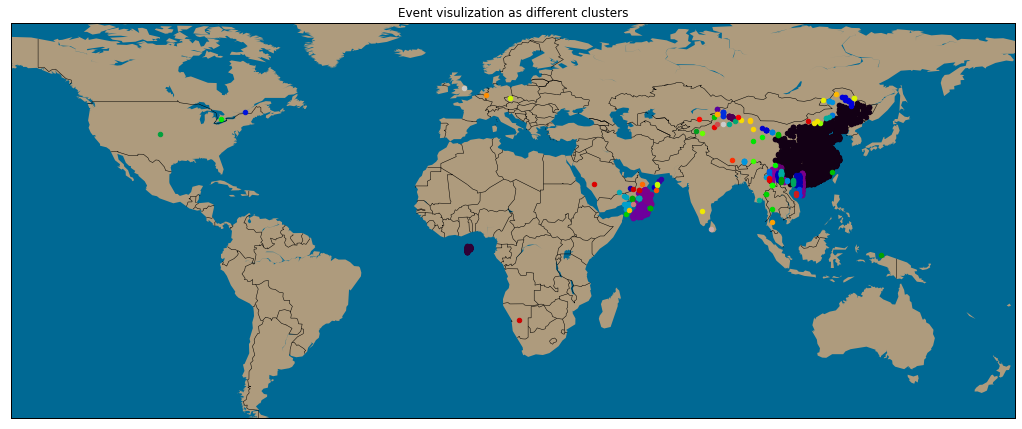

In [111]:
#Plotting the clusters
plt.figure(figsize = (18,25))
# Mercator of World
m = Basemap(projection='merc', resolution='c', epsg = 4269, 
            llcrnrlat=-55,  #latitude of lower left hand corner of the desired map domain
             urcrnrlat=75, #latitude of upper right hand corner of the desired map domain
             llcrnrlon=-150, #longitude of lower left hand corner of the desired map domain
             urcrnrlon=180, #longitude of upper right hand corner of the desired map domain
             lat_ts=0) #resolution of boundary dataset being used - c for crude
unique_label = np.unique(cluster_labels)

# get different color for different cluster
cmaps = get_cmap(num_clusters)
m.fillcontinents(color='#ae9b7d',lake_color='#006994') # sand beige land, ocean blue
m.drawmapboundary(fill_color='#006994')                # ocean blue background
m.drawcountries(linewidth=0.5)              # thin black line for country borders
# plot different clusters on map, note that the black dots are 
# outliers that not belone to any cluster. 
for i, cluster in enumerate(clusters):
    lons_select = cluster[:, 1]
    lats_select = cluster[:, 0]
    x, y = m(lons_select, lats_select)
    m.scatter(x,y,marker='o',s=20,color=cmaps(i),zorder = 10)
plt.title("Event visulization as different clusters")
plt.show()

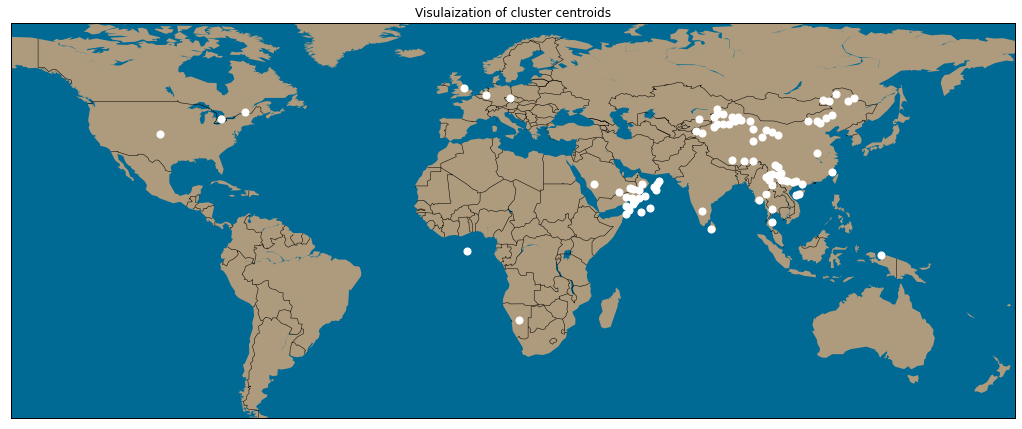

In [112]:
plt.figure(figsize = (18,25))
m = Basemap(projection='merc', resolution='c', epsg = 4269, 
            llcrnrlat=-55,  #latitude of lower left hand corner of the desired map domain
             urcrnrlat=75, #latitude of upper right hand corner of the desired map domain
             llcrnrlon=-150, #longitude of lower left hand corner of the desired map domain
             urcrnrlon=180, #longitude of upper right hand corner of the desired map domain
             lat_ts=0) #resolution of boundary dataset being used - c for crude

m.fillcontinents(color='#ae9b7d',lake_color='#006994') # sand beige land, ocean blue
m.drawmapboundary(fill_color='#006994')                # ocean blue background
m.drawcountries(linewidth=0.5)              # thin black line for country borders
m.scatter(rep_points.iloc[:,0:1],rep_points.iloc[:,1:2],marker='o', s=50, c="white", zorder=2)
plt.title("Visulaization of cluster centroids")
plt.show()

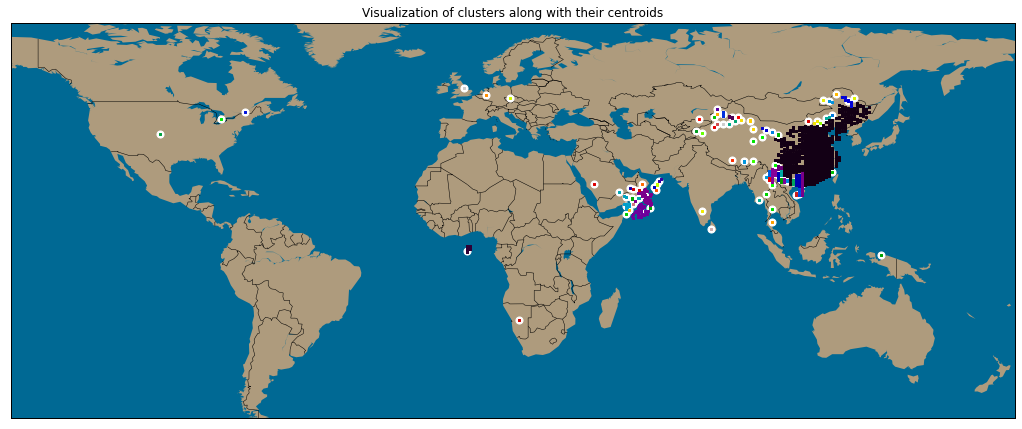

In [113]:
plt.figure(figsize = (18,25))
m = Basemap(projection='merc', resolution='c', epsg = 4269, 
            llcrnrlat=-55,  #latitude of lower left hand corner of the desired map domain
             urcrnrlat=75, #latitude of upper right hand corner of the desired map domain
             llcrnrlon=-150, #longitude of lower left hand corner of the desired map domain
             urcrnrlon=180, #longitude of upper right hand corner of the desired map domain
             lat_ts=0) #resolution of boundary dataset being used - c for crude

unique_label = np.unique(cluster_labels)

# get different color for different cluster
cmaps = get_cmap(num_clusters)
m.fillcontinents(color='#ae9b7d',lake_color='#006994') # sand beige land, ocean blue
m.drawmapboundary(fill_color='#006994')                # ocean blue background
m.drawcountries(linewidth=0.5)              # thin black line for country borders
# plot different clusters on map, note that the black dots are 
# outliers that not belone to any cluster. 
m.scatter(rep_points.iloc[:,0:1],rep_points.iloc[:,1:2],marker='o', s=50, c="white", zorder=2)
for i, cluster in enumerate(clusters):
    lons_select = cluster[:, 1]
    lats_select = cluster[:, 0]
    x, y = m(lons_select, lats_select)
    m.scatter(x,y,marker=',', s=3,color=cmaps(i), zorder = 10)
plt.title("Visualization of clusters along with their centroids")
plt.show()

In [114]:
#first 5 rows
devices_with_events.head()

,device_id,gender,age,brand,model,event_id,longitude,latitude,midnight_counts,daytime_counts,...,night_counts,monday_counts,tuesday_counts,wednesday_counts,thursday_counts,friday_counts,saturday_counts,sunday_counts,category,cluster
0,-7548291590301750000,M,33,Huawei,è£è€€3C,1357153.0,116.0,33.980,73.0,166.0,...,22.0,62.0,86.0,93.0,6.0,0.0,0.0,45.0,"industry tag,nature ,personal effectiveness ,i...",0
1,-1819925713085810000,F,23,OPPO,N1 Mini,1097259.0,114.0,36.325,13.0,16.0,...,4.0,12.0,5.0,6.0,4.0,3.0,4.0,6.0,"industry tag,im,relatives ,notes,personal effe...",0
2,3670076507269740000,M,33,Meizu,menote1 2,1852419.0,0.0,0.000,28.0,56.0,...,12.0,21.0,18.0,19.0,17.0,7.0,16.0,13.0,"radio,industry tag,cozy ,services",1
3,5333872006968810000,M,34,Xiaomi,xnote,1324905.0,87.0,43.960,6.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,5.0,"debit and credit,others,im,industry tag,relati...",2
4,5263633571423510000,M,27,Huawei,hu1 Plus,1390606.0,114.0,30.390,10.0,27.0,...,0.0,3.0,8.0,6.0,4.0,9.0,7.0,0.0,"im,industry tag,relatives ,services ,weibo,not...",0


In [115]:
#shape
devices_with_events.shape

(23311, 21)

# Final Datasets

## Scenario 1 (with user information)

In [116]:
#subsetting data for scenario 1
scenario_1= final_df[(final_df['event_id'].isna()==False)]

In [117]:
#merging with devices_with events
scenario_1 = pd.merge(scenario_1, devices_with_events[["device_id", "cluster"]], on="device_id", how="left")

In [118]:
#shape
scenario_1.shape

(23313, 21)

In [119]:
#basic info
scenario_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23313 entries, 0 to 23312
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   device_id             23313 non-null  int64  
 1   gender                23313 non-null  object 
 2   age                   23313 non-null  int64  
 3   brand                 23313 non-null  object 
 4   model                 23313 non-null  object 
 5   event_id              23313 non-null  float64
 6   longitude             23313 non-null  float64
 7   latitude              23313 non-null  float64
 8   midnight_counts       23313 non-null  float64
 9   daytime_counts        23313 non-null  float64
 10  early_morning_counts  23313 non-null  float64
 11  night_counts          23313 non-null  float64
 12  monday_counts         23313 non-null  float64
 13  tuesday_counts        23313 non-null  float64
 14  wednesday_counts      23313 non-null  float64
 15  thursday_counts    

In [120]:
scenario_1=scenario_1.dropna()

In [121]:
#first five rows
scenario_1.head()

,device_id,gender,age,brand,model,event_id,longitude,latitude,midnight_counts,daytime_counts,...,night_counts,monday_counts,tuesday_counts,wednesday_counts,thursday_counts,friday_counts,saturday_counts,sunday_counts,category,cluster
0,-7548291590301750000,M,33,Huawei,è£è€€3C,1357153.0,116.0,33.980,73.0,166.0,...,22.0,62.0,86.0,93.0,6.0,0.0,0.0,45.0,"industry tag,nature ,personal effectiveness ,i...",0
1,-1819925713085810000,F,23,OPPO,N1 Mini,1097259.0,114.0,36.325,13.0,16.0,...,4.0,12.0,5.0,6.0,4.0,3.0,4.0,6.0,"industry tag,im,relatives ,notes,personal effe...",0
2,3670076507269740000,M,33,Meizu,menote1 2,1852419.0,0.0,0.000,28.0,56.0,...,12.0,21.0,18.0,19.0,17.0,7.0,16.0,13.0,"radio,industry tag,cozy ,services",1
3,5333872006968810000,M,34,Xiaomi,xnote,1324905.0,87.0,43.960,6.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,5.0,"debit and credit,others,im,industry tag,relati...",2
4,5263633571423510000,M,27,Huawei,hu1 Plus,1390606.0,114.0,30.390,10.0,27.0,...,0.0,3.0,8.0,6.0,4.0,9.0,7.0,0.0,"im,industry tag,relatives ,services ,weibo,not...",0


In [122]:
#dropping event_id,latitude and longitude column since cluster label refers to location
scenario_1=scenario_1.drop(scenario_1.iloc[:,5:8], axis=1)

In [123]:
scenario_1.columns

Index(['device_id', 'gender', 'age', 'brand', 'model', 'midnight_counts',
       'daytime_counts', 'early_morning_counts', 'night_counts',
       'monday_counts', 'tuesday_counts', 'wednesday_counts',
       'thursday_counts', 'friday_counts', 'saturday_counts', 'sunday_counts',
       'category', 'cluster'],
      dtype='object')

In [124]:
#rearranging columns
scenario_1 = scenario_1[['device_id','brand','model','midnight_counts','daytime_counts', 'early_morning_counts', 'night_counts','monday_counts', 'tuesday_counts', 'wednesday_counts','thursday_counts', 'friday_counts', 'saturday_counts', 'sunday_counts','category', 'cluster','gender', 'age']]

In [125]:
#dropping duplicates
scenario_1.drop_duplicates(inplace=True)

In [126]:
scenario_1.head()

,device_id,brand,model,midnight_counts,daytime_counts,early_morning_counts,night_counts,monday_counts,tuesday_counts,wednesday_counts,thursday_counts,friday_counts,saturday_counts,sunday_counts,category,cluster,gender,age
0,-7548291590301750000,Huawei,è£è€€3C,73.0,166.0,31.0,22.0,62.0,86.0,93.0,6.0,0.0,0.0,45.0,"industry tag,nature ,personal effectiveness ,i...",0,M,33
1,-1819925713085810000,OPPO,N1 Mini,13.0,16.0,7.0,4.0,12.0,5.0,6.0,4.0,3.0,4.0,6.0,"industry tag,im,relatives ,notes,personal effe...",0,F,23
2,3670076507269740000,Meizu,menote1 2,28.0,56.0,15.0,12.0,21.0,18.0,19.0,17.0,7.0,16.0,13.0,"radio,industry tag,cozy ,services",1,M,33
3,5333872006968810000,Xiaomi,xnote,6.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,5.0,"debit and credit,others,im,industry tag,relati...",2,M,34
4,5263633571423510000,Huawei,hu1 Plus,10.0,27.0,0.0,0.0,3.0,8.0,6.0,4.0,9.0,7.0,0.0,"im,industry tag,relatives ,services ,weibo,not...",0,M,27


In [127]:
scenario_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23144 entries, 0 to 23312
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   device_id             23144 non-null  int64  
 1   brand                 23144 non-null  object 
 2   model                 23144 non-null  object 
 3   midnight_counts       23144 non-null  float64
 4   daytime_counts        23144 non-null  float64
 5   early_morning_counts  23144 non-null  float64
 6   night_counts          23144 non-null  float64
 7   monday_counts         23144 non-null  float64
 8   tuesday_counts        23144 non-null  float64
 9   wednesday_counts      23144 non-null  float64
 10  thursday_counts       23144 non-null  float64
 11  friday_counts         23144 non-null  float64
 12  saturday_counts       23144 non-null  float64
 13  sunday_counts         23144 non-null  float64
 14  category              23144 non-null  object 
 15  cluster            

## Scenario 2 (without user information)

In [128]:
scenario_2 = final_df[(final_df['event_id'].isna()==True)]

In [129]:
scenario_2.shape

(51335, 20)

In [130]:
scenario_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51335 entries, 7229 to 74645
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   device_id             51335 non-null  int64  
 1   gender                51335 non-null  object 
 2   age                   51335 non-null  int64  
 3   brand                 51335 non-null  object 
 4   model                 51335 non-null  object 
 5   event_id              0 non-null      float64
 6   longitude             0 non-null      float64
 7   latitude              0 non-null      float64
 8   midnight_counts       0 non-null      float64
 9   daytime_counts        0 non-null      float64
 10  early_morning_counts  0 non-null      float64
 11  night_counts          0 non-null      float64
 12  monday_counts         0 non-null      float64
 13  tuesday_counts        0 non-null      float64
 14  wednesday_counts      0 non-null      float64
 15  thursday_counts 

In [131]:
scenario_2.head()

,device_id,gender,age,brand,model,event_id,longitude,latitude,midnight_counts,daytime_counts,early_morning_counts,night_counts,monday_counts,tuesday_counts,wednesday_counts,thursday_counts,friday_counts,saturday_counts,sunday_counts,category
7229,398514470209561000,M,68,Huawei,è£è€€ç•…çŽ©4X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
7230,5805880616488060000,M,39,others,è¶…çº§æ‰‹æœº1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
7231,-1889893391998300000,M,22,Huawei,è£è€€3Xç•…çŽ©ç‰ˆ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
7232,3422421754497040000,M,27,samsung,Galaxy Note 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
7233,3221871111026990000,M,29,Huawei,è£è€€ç•…çŽ©4X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


In [132]:
scenario_2 = scenario_2[['device_id','brand','model','gender', 'age']]

In [133]:
scenario_2.head()

,device_id,brand,model,gender,age
7229,398514470209561000,Huawei,è£è€€ç•…çŽ©4X,M,68
7230,5805880616488060000,others,è¶…çº§æ‰‹æœº1,M,39
7231,-1889893391998300000,Huawei,è£è€€3Xç•…çŽ©ç‰ˆ,M,22
7232,3422421754497040000,samsung,Galaxy Note 3,M,27
7233,3221871111026990000,Huawei,è£è€€ç•…çŽ©4X,M,29


# Exporting Data to S3

In [134]:
import awswrangler as wr
wr.s3.to_parquet(
    df=scenario_1,
    path="s3://capstonemlc/Final_data/scenario_1.parquet"
)

{'paths': ['s3://capstonemlc/Final_data/scenario_1.parquet'],
 'partitions_values': {}}

In [135]:
wr.s3.to_parquet(
    df=scenario_2,
    path="s3://capstonemlc/Final_data/scenario_2.parquet"
)

{'paths': ['s3://capstonemlc/Final_data/scenario_2.parquet'],
 'partitions_values': {}}